In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.notebook import tqdm
from collections import namedtuple

from definitions import ROOT_DIR
from unc.utils import load_info

In [25]:
rg_path = Path(ROOT_DIR, 'results', 'rg')
rxg_path = Path(ROOT_DIR, 'results', 'rxg')
rpg_path = Path(ROOT_DIR, 'results', 'rpg')
rsg_path = Path(ROOT_DIR, 'results', 'rsg')

split_by = ['buffer_size', 'step_size', 'algo']
Args = namedtuple('args', split_by)

rg_color = 'black'
rxg_color = 'purple'
rsg_color = 'darkorange'
rpg_color = 'forestgreen'


def moving_avg(x, mode='valid', w=100):
    return np.convolve(x, np.ones(w), mode=mode) / w

In [29]:
rsg_infos = [load_info(f) for f in tqdm(rsg_path.iterdir())]
rpg_infos = [load_info(f) for f in tqdm(rpg_path.iterdir())]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [26]:
def get_discounted_returns(ep_lengths, ep_rews, discount=0.99):
    assert ep_lengths.sum() == ep_rews.shape[0]

    discounted_returns = []
    current_ep_disc_rew = 0
    idx = 0

    for ep_len in ep_lengths:
        for i in range(ep_len):
            current_ep_disc_rew += ep_rews[idx] * (discount ** i)
            idx += 1
        discounted_returns.append(current_ep_disc_rew)
        current_ep_disc_rew = 0
    discounted_returns = np.array(discounted_returns)
    
    assert discounted_returns.shape[0] == ep_lengths.shape[0]
    
    return discounted_returns

In [27]:
def process_dir(dir_path, w=100, split_by=None, discount=0.99):
    if split_by is not None:
        all_results = {}
    else:
        all_results = []
        
    for f in tqdm(list(dir_path.iterdir())):
        info = load_info(f)
        args = info['args'].item()
        
        result = get_discounted_returns(info['episode_length'], info['reward'], discount)

        if split_by is not None:
            hparams = Args(*tuple(args[s] for s in split_by))
            
            if hparams not in all_results:
                all_results[hparams] = []
                
            all_results[hparams].append((info['episode_length'], result))
            
        else:
            all_results.append((info['episode_length'], result))
            
#     if split_by is not None:
#         for k, v in all_results.items():
#             for k1, v1 in v.items():
#                 all_results[k][k1] = np.array(all_results[k][k1])
#         data = all_results
#     else:
#         data = np.array(all_results)

    
    return all_results


In [ ]:
discount = 0.99
rg_data = process_dir(rg_path, split_by=split_by, discount=discount)
rxg_data = process_dir(rxg_path, split_by=split_by, discount=discount)
rpg_data = process_dir(rpg_path, split_by=split_by, discount=discount)
rsg_data = process_dir(rsg_path, split_by=split_by, discount=discount)

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

In [7]:
# we average the discounted episodic rewards over the final 100 episodes.

def get_eps_max_over(data, eps_max_over=100):
    hparam_results = []
    for args, all_dis_rew in data.items():
        final_max = np.mean([np.mean(dis_rew[-100:]) for length, dis_rew in all_dis_rew])
        hparam_results.append((args, final_max))
    return hparam_results


In [10]:
eps_max_over = 100
rg_max_over = get_eps_max_over(rg_data, eps_max_over)
rxg_max_over = get_eps_max_over(rxg_data, eps_max_over)
rpg_max_over = get_eps_max_over(rpg_data, eps_max_over)
rsg_max_over = get_eps_max_over(rsg_data, eps_max_over)

In [12]:
# Get the best hyperparams based on the final 100 episodes
rg_best = sorted(rg_max_over, key=lambda x : x[1], reverse=True)[0]
rxg_best = sorted(rxg_max_over, key=lambda x : x[1], reverse=True)[0]
rpg_best = sorted(rpg_max_over, key=lambda x : x[1], reverse=True)[0]
rsg_best = sorted(rsg_max_over, key=lambda x : x[1], reverse=True)[0]

rg_best, rxg_best, rpg_best, rsg_best

((args(buffer_size=100000, step_size=0.0001, algo='sarsa'), 9.98069389677821),
 (args(buffer_size=100000, step_size=0.0001, algo='sarsa'),
  12.173340024340781),
 (args(buffer_size=100000, step_size=0.001, algo='sarsa'), 31.320537655979468),
 (args(buffer_size=100000, step_size=0.0001, algo='sarsa'), 33.93413421504428))

In [21]:
# Now we map our discounted episodic rewards back to steps. We assign the discounted reward achieved at the 
# end of and episode to each timestep within the episode


def map_dis_rew_to_steps(data, w=1000, trunc=1e6):
    all_seeds = []
    for lengths, dis_rews in data:
        current_seed = []
        for length, dis_rew in zip(lengths, dis_rews):
            current_seed.append(np.zeros(length) + dis_rew)
        all_seeds.append(moving_avg(np.concatenate(current_seed)[:trunc], w=w))
    return np.array(all_seeds)

In [22]:
trunc = int(1.5e6)

rg_best_data = rg_data[rg_best[0]]
rxg_best_data = rxg_data[rxg_best[0]]
rpg_best_data = rpg_data[rpg_best[0]]
rsg_best_data = rsg_data[rsg_best[0]]

mapped_rg = map_dis_rew_to_steps(rg_best_data, trunc=trunc)
mapped_rxg = map_dis_rew_to_steps(rxg_best_data, trunc=trunc)
mapped_rpg = map_dis_rew_to_steps(rpg_best_data, trunc=trunc)
mapped_rsg = map_dis_rew_to_steps(rsg_best_data, trunc=trunc)

In [23]:
all_data = [
    ('Normal obs', mapped_rg, rg_color),
    ('Ground-truth check obs', mapped_rxg, rxg_color),
    ('PF obs', mapped_rpg, rpg_color),
    ('Ground-truth obs', mapped_rsg, rsg_color)
]

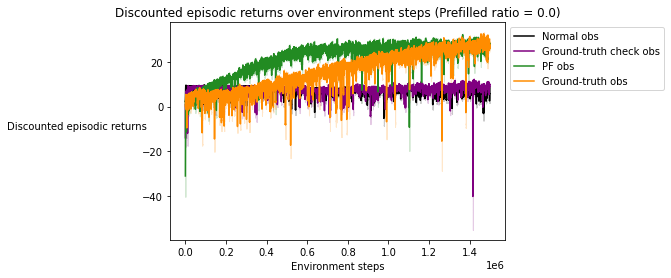

In [24]:
x = np.arange(mapped_rg.shape[1])
fig, ax = plt.figure(), plt.axes()


for key, data, color in all_data:
    means = data.mean(axis=0)
    std_err = data.std(axis=0) / data.shape[0]

    ax.plot(x, means, label=key, color=color)
    plt.fill_between(x, means - std_err, means + std_err,
                         color=color, alpha=0.2)

ax.set_xlabel('Environment steps')
ax.set_ylabel(f"Discounted episodic returns", rotation=0, labelpad=65)
ax.set_title(f'Discounted episodic returns over environment steps (Prefilled ratio = 0.0)')
plt.legend(bbox_to_anchor=(1.00, 1), loc='upper left')


In [87]:
# Now for RPG q-learning vs esarsa vs sarsa plots
def group_by(dataset, key):
    grouped_data = {}
    for args, d in dataset.items():
        key_val = getattr(args, key)
        if key_val not in grouped_data:
            grouped_data[key_val] = {}
        
        grouped_data[key_val][args] = d
    return grouped_data

In [88]:
key = 'algo'
rpg_grouped_alg = group_by(rpg_data, key)

In [89]:
rpg_algo_max_overs = {}
for algo, d in rpg_grouped_alg.items():
    rpg_algo_max_overs[algo] = get_eps_max_over(d, eps_max_over=100)

In [91]:
rpg_algo_maxes = {}
for algo, d in rpg_algo_max_overs.items():
    rpg_algo_maxes[algo] = sorted(d, key=lambda x : x[1], reverse=True)[0]

In [97]:
mapped_rpg_algo_data = {}
for alg, (hparams, _) in rpg_algo_maxes.items():
    mapped_rpg_algo_data[alg] = map_dis_rew_to_steps(rpg_grouped_alg[alg][hparams])

In [103]:
plot_params = {
    'esarsa': {'color': 'orange'},
    'qlearning': {'color': 'blue'},
    'sarsa': {'color': 'red'}
              }

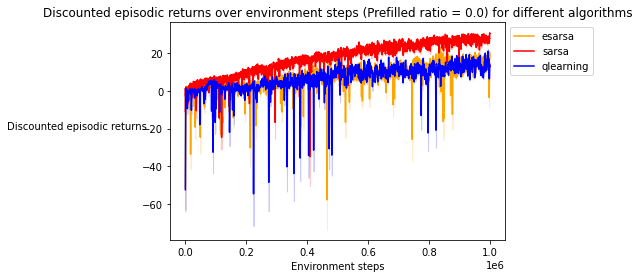

In [104]:
x_alg = np.arange(mapped_rpg_algo_data['sarsa'].shape[1])
alg_fig, alg_ax = plt.figure(), plt.axes()


for key, data in mapped_rpg_algo_data.items():
    means = data.mean(axis=0)
    std_err = data.std(axis=0) / data.shape[0]

    alg_ax.plot(x_alg, means, label=key, color=plot_params[key]['color'])
    plt.fill_between(x_alg, means - std_err, means + std_err,
                         color=plot_params[key]['color'], alpha=0.2)

alg_ax.set_xlabel('Environment steps')
alg_ax.set_ylabel(f"Discounted episodic returns", rotation=0, labelpad=65)
alg_ax.set_title(f'Discounted episodic returns over environment steps (Prefilled ratio = 0.0) for different algorithms')
plt.legend(bbox_to_anchor=(1.00, 1), loc='upper left')
